In [2]:
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
from scipy.interpolate import interp1d
import pandas as pd
from scipy.special import jv
from scipy.linalg import solve_sylvester
from scipy.interpolate import interp1d


def log_transform(im):
    '''returns log(image) scaled to have the sam max and min'''
    try:
        (min, max) = (im.min(), im.max())
        return max*(np.log(im) - np.log(min)) / (np.log(max) - np.log(min))
    except:
        pass
    return im

def get_square_H(s,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    dx = s/resolution #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize data matrix
    # Ymat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize B matrix
    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 

    H_beta_x = -H0*beta_x

    C[0][0] = 2*H_beta_x
    C[resolution-1][0] = 2*H_beta_x
    C[0][resolution-1] = 2*H_beta_x
    C[resolution-1][resolution-1] = 2*H_beta_x

    for i in range(1,resolution-1):
        C[0][i] = H_beta_x
        C[resolution-1][i] = H_beta_x
        C[i][0] = H_beta_x
        C[i][resolution-1] = H_beta_x
        
    X = solve_sylvester(Xmat,Xmat,C)
    
    for i in range(resolution):
        for j in range(resolution):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).
    # print(X-solve_sylvester(Xmat,Xmat,C))             
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_cylind_H(d,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    cylindH = H0 * np.ones([resolution+2,resolution+2],dtype=np.complex_)
    for i in range(resolution+2):
        for j in range(resolution+2):
            r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*d
            if r<=d/2:
                # print(np.sqrt((i-(resolution+2)/2)**2 + (j-(resolution+2)/2)**2)/(resolution+2),end='')
                cylindH[i][j] = jv(0,r*k)/jv(0,d/2*k)
    return cylindH

def get_shape_H_old(shape_data,s,skin_depth,resolution,H0=1):
    k=(1-1j)/skin_depth #k value 
    
    #This analysis is only useful if there are many more divisions per unit length than the inverse of 
    #the skin depth (Otherwise, valuable information is missed). This is 
    #the reason for increasing the resolution at small skin depths: div 
    #is res by default but becomes larger if the skin depth is sufficiently small.
    
    dx = s/(resolution) #stepsize: x direction
    # Because the input matrix shape_data must be square, dx=dy

    """This analysis solves the differential equation del^2(H)+k^2*H=0 over 
    an arbitary shaped sample. A second order approximation for H is used, which 
    is appropriate given the presence of the Laplacian."""

    k = (1+1j)/skin_depth
    dx = s/resolution #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    # dy = s/resolution #stepsize: y direction
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize A matrix
    print(np.absolute(k**2),beta_x)

    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 
    
    H_beta_x = -H0*beta_x
    k2 = k**2

    #corners
    if not(shape_data[0][0]):
        C[0][0] = 2*H_beta_x + k2
    else:
        C[0][0] = 2*H_beta_x
    if not(shape_data[resolution-1][0]):
        C[resolution-1][0] = 2*H_beta_x + k2
    else:
        C[resolution-1][0] = 2*H_beta_x
    if not(shape_data[0][resolution-1]):
        C[0][resolution-1] = 2*H_beta_x + k2
    else:
        C[0][resolution-1] = 2*H_beta_x
    if not(shape_data[resolution-1][resolution-1]):
        C[resolution-1][resolution-1] = 2*H_beta_x + k2
    else:
        C[resolution-1][resolution-1] = 2*H_beta_x
    

    #edges
    for i in range(1,resolution-1):
        if not(shape_data[0][i]):
            C[0][i] = H_beta_x + k2
        else:
            C[0][i] = H_beta_x
        if not(shape_data[resolution-1][i]):
            C[resolution-1][i] = H_beta_x + k2
        else:
            C[resolution-1][i] = H_beta_x
        if not(shape_data[i][0]):
            C[i][0] = H_beta_x + k2
        else:
            C[i][0] = H_beta_x
        if not(shape_data[i][resolution-1]):
            C[i][resolution-1] = H_beta_x + k2
        else:
            C[i][resolution-1] = H_beta_x
        
    #interior
    for i in range(1,resolution-1):
        for j in range(1,resolution-1):
            if shape_data[i][j]:
                C[i][j] = k2
    # print(Xmat,C)

    X = solve_sylvester(Xmat,Xmat,C)
                
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    x = np.linspace(0, s, resolution)  # x-axis points
    dx = x[1] - x[0]  # grid spacing in x

    # Define the initial condition
    z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
    #             # shape_inds = np.append(shape_inds,(i,j))


    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # for n in range(iterations):
    #     old_z = z.copy()
    #     for i in range(1, resolution - 1):  # loop over the interior points in x
    #         for j in range(1, resolution - 1):  # loop over the interior points in y
    #             if mask[i, j] == 1:  # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (old_z[i+1, j] + old_z[i-1, j] + old_z[i, j+1] + old_z[i, j-1]) * inv_denom

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])

    # Time to iterate_new ...slower??
    # inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # inx = np.transpose(np.where(mask == 0))
    # print(inx)
    # for n in range(iterations):
    #     for i,j in inx: # loop over the interior points in   
    #                 # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    return z

def get_skin_depth(rho,frequency=671111):
    return (2*rho/(4e-7*np.pi*2 * np.pi *frequency))**.5

def adjustsize(data, start,end,resolution,outside_val=0):
    if end < start:
        return data
    n = int(end/start*resolution) #new matrix size
    starting_ind = int(resolution*(end/start-1)/2)
    output = np.zeros([n,n],dtype=np.complex_)+outside_val
    for i in range(resolution+2):# assuming the matrix has an outside row of 1s, so its size is resolution +2
        for j in range(resolution+2):
            output[starting_ind + i - 1][starting_ind + j - 1] = data[i][j]
    return output

def double_Integral(data, d):
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

Text(0.5, 1.0, '1 mm$^2$ Copper Triangle Cross Section')

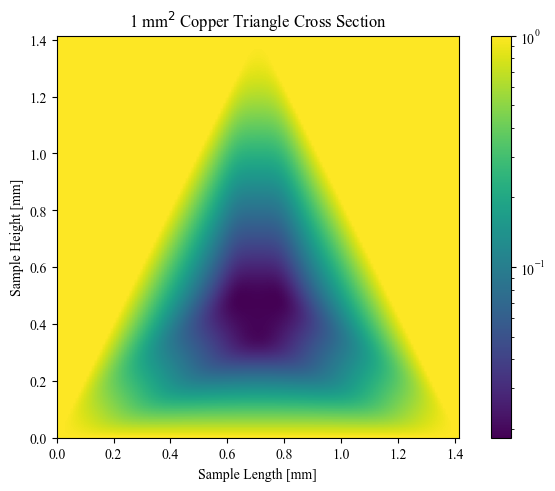

In [79]:
tri_resolution = 150
iter = 15000
l = 2**(.5)*1e-3 #this is the legnth of all the sides of triangle. This will gave an area of 1mm^2
tri_data = np.zeros([tri_resolution,tri_resolution])
for i in range(tri_resolution):
    for j in range(tri_resolution):
        if i>=2*abs(j-(tri_resolution-1)/2):# or i<=2*abs(j-(tri_resolution-1)/2):
            tri_data[i][j] = 1

# print(tri_data)

tri_H = get_shape_H(tri_data,l,get_skin_depth(2e-8),iter)
# tri_H = get_shape_H(np.zeros([tri_resolution,tri_resolution]),l,get_skin_depth(2e-6),tri_resolution)

fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(1, 1, 1)

p1 = ax.imshow(np.absolute(tri_H ),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=np.absolute(tri_H).min(), vmax=1))#,norm=colors.LogNorm(vmin=min(np.absolute(tri_H )), vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

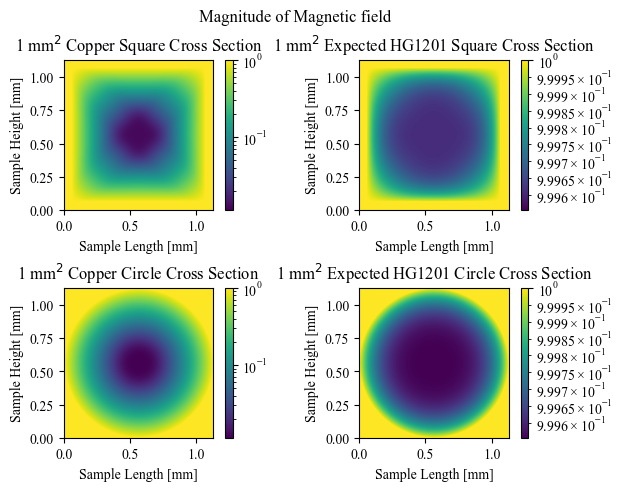

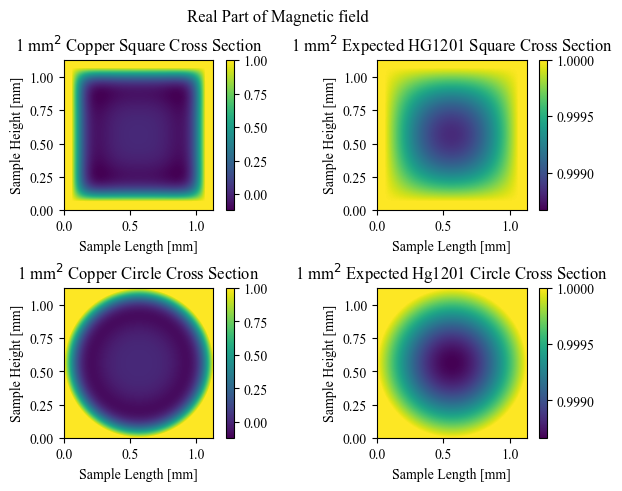

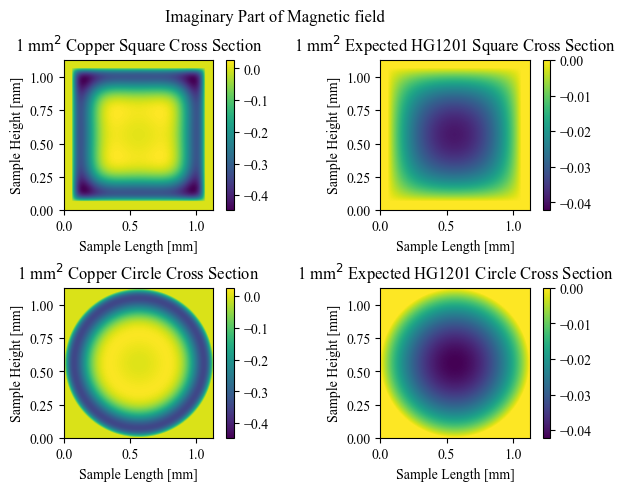

In [80]:
#################################
# Geometry Effects Plotting
#################################

cylind_resolution = 150
square_resolution = 150
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters

rho = np.array([2e-8,1000e-8]) #resistivities in ohm*m
skin_depths = get_skin_depth(rho)
CopperSquare = get_square_H(s,skin_depths[0],square_resolution)
CopperCylind = get_cylind_H(d,skin_depths[0],cylind_resolution)
InsolSquare = get_square_H(s,skin_depths[1],square_resolution)
InsolCylind = get_cylind_H(d,skin_depths[1],cylind_resolution)

CopperSquare_ad = adjustsize(CopperSquare,1,2/np.pi**.5,square_resolution,1)
InsolSquare_ad = adjustsize(InsolSquare,1,2/np.pi**.5,square_resolution,1)

# old = CopperSquare[len(CopperSquare)//2][0]
# count = 0
# print(CopperSquare[len(CopperSquare)//2])
# for i, a in enumerate(CopperSquare[len(CopperSquare)//2]):
#     if old == a[i]:
#         count+=1
#     elif old%1 ==0:
#         print(count)
#         count = 0
#     old = a[i]
# print(count)

coppermin = min(np.absolute(CopperSquare).min(),np.absolute(CopperCylind).min())
insolmin = min(np.absolute(InsolSquare).min(),np.absolute(InsolCylind).min())


fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)
fig.suptitle('Magnitude of Magnetic field')

p1 = ax.imshow(np.absolute(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.absolute(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.absolute(CopperCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length [mm]')
cx.set_ylabel('Sample Height [mm]')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.absolute(InsolCylind),extent=[0, d*1e3, 0, d*1e3],norm=colors.LogNorm(vmin=insolmin, vmax=1))
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length [mm]')
dx.set_ylabel('Sample Height [mm]')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')
plt.show()

coppermin = min(np.real(CopperSquare).min(),np.real(CopperCylind).min())
insolmin = min(np.real(InsolSquare).min(),np.real(InsolCylind).min())
coppermax = max(np.real(CopperSquare).max(),np.real(CopperCylind).max())
insolmax = min(np.real(InsolSquare).max(),np.real(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Real Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.real(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.real(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.real(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length [mm]')
cx.set_ylabel('Sample Height [mm]')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.real(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length [mm]')
dx.set_ylabel('Sample Height [mm]')
dx.set_title(r'1 mm$^2$ Expected Hg1201 Circle Cross Section')
plt.show()

coppermin = min(np.imag(CopperSquare).min(),np.imag(CopperCylind).min())
insolmin = min(np.imag(InsolSquare).min(),np.imag(InsolCylind).min())
coppermax  = max(np.imag(CopperSquare).max(),np.imag(CopperCylind).max())
insolmax = max(np.imag(InsolSquare).max(),np.imag(InsolCylind).max())

fig = plt.figure(constrained_layout = True)
fig.suptitle('Imaginary Part of Magnetic field')
ax = fig.add_subplot(2, 2, 1)
bx = fig.add_subplot(2, 2, 2)
cx = fig.add_subplot(2, 2, 3)
dx = fig.add_subplot(2, 2, 4)

p1 = ax.imshow(np.imag(CopperSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')

p2 = bx.imshow(np.imag(InsolSquare_ad),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'1 mm$^2$ Expected HG1201 Square Cross Section')

p3 = cx.imshow(np.imag(CopperCylind),extent=[0, d*1e3, 0, d*1e3],vmin=coppermin, vmax=coppermax)
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length [mm]')
cx.set_ylabel('Sample Height [mm]')
cx.set_title(r'1 mm$^2$ Copper Circle Cross Section')

p4 = dx.imshow(np.imag(InsolCylind),extent=[0, d*1e3, 0, d*1e3],vmin=insolmin, vmax=insolmax)
fig.colorbar(p4, ax=dx)
dx.set_xlabel('Sample Length [mm]')
dx.set_ylabel('Sample Height [mm]')
dx.set_title(r'1 mm$^2$ Expected HG1201 Circle Cross Section')

plt.show()

Text(0.5, 1.0, '1 mm$^2$ Copper Triangle Cross Section')

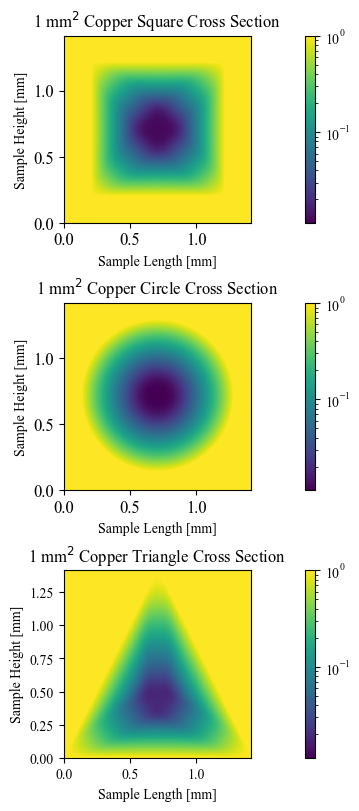

In [81]:
CopperSquare_ad = adjustsize(CopperSquare,s,l,square_resolution,1)
CopperCylind_ad = adjustsize(CopperCylind,d,l,cylind_resolution,1)

coppermin = min(np.absolute(CopperSquare).min(),np.absolute(CopperCylind).min(),np.absolute(tri_H).min())

fig = plt.figure(constrained_layout = True,figsize=(12,8))
ax = fig.add_subplot(3, 1, 1)
bx = fig.add_subplot(3, 1, 2)
cx = fig.add_subplot(3, 1, 3)
p1 = ax.imshow(np.absolute(CopperSquare_ad),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'1 mm$^2$ Copper Square Cross Section')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

p2 = bx.imshow(np.absolute(CopperCylind_ad),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p2, ax=bx)
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'1 mm$^2$ Copper Circle Cross Section')
bx.tick_params(axis='x', labelsize=12)
bx.tick_params(axis='y', labelsize=12)

p3 = cx.imshow(np.absolute(tri_H),extent=[0, l*1e3, 0, l*1e3],norm=colors.LogNorm(vmin=coppermin, vmax=1))
fig.colorbar(p3, ax=cx)
cx.set_xlabel('Sample Length [mm]')
cx.set_ylabel('Sample Height [mm]')
cx.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

In [3]:
########################################
# Magnetic Susecptibility v Resistivity
########################################

rhos = np.logspace(-9,-4,100)
chis = np.zeros(len(rhos),dtype=np.complex_) #Stores the effective magnetic susceptibility of cylinder
chis2 = np.zeros(len(rhos),dtype=np.complex_) #square
analchis = np.zeros(len(rhos),dtype=np.complex_)#analytical solution for cylinder
s = 1e-3 # length in meters
d = 2e-3/np.pi**.5 #diameter in meters
a=d/2 #radius

resolution = 150
H0 = 1
for i, rho in enumerate(rhos):
    delta = get_skin_depth(rho)
    k =(1-1j)/delta
    cylind = get_cylind_H(d,delta,resolution)
    Square = get_square_H(s,delta,resolution)
    chis[i] = double_Integral(cylind,d)/d**2-1
    chis2[i] = double_Integral(Square,s)/s**2-1
    analchis[i] = 2/a/k*jv(1,a*k)/jv(0,a*k)-1
Phase2Resistivty = interp1d(np.angle(analchis),rhos) #this is the big headline. Now we can convert a measured phase to resistivity


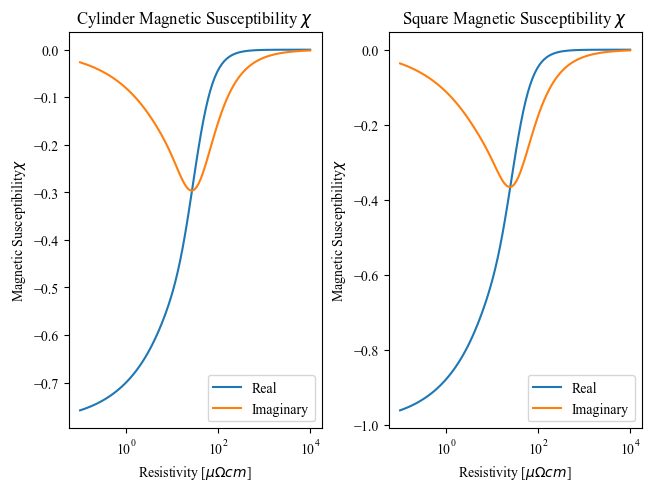

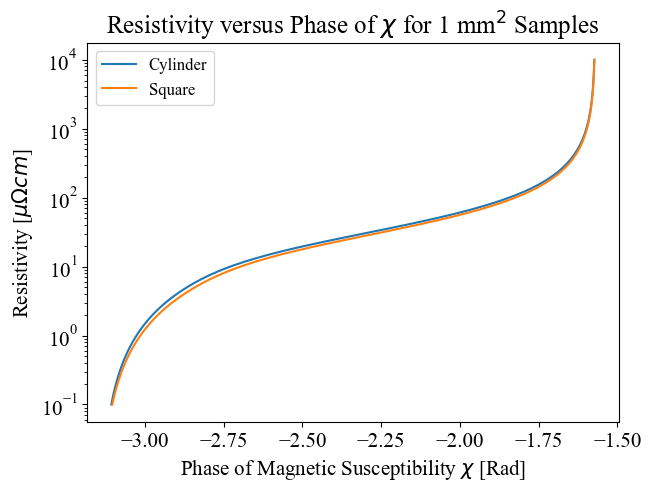

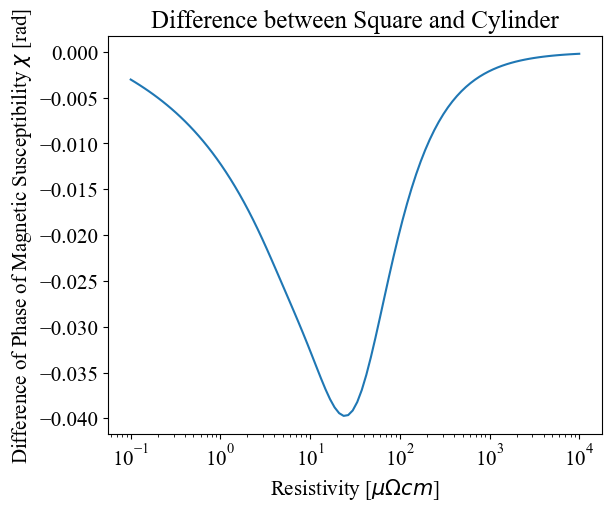

In [83]:
fig1 = plt.figure(constrained_layout = True)
fig2 = plt.figure(constrained_layout = True)
fig3 = plt.figure(constrained_layout = True, figsize=(6, 5))
ax = fig1.add_subplot(1, 2, 1)
bx = fig1.add_subplot(1, 2, 2)
cx = fig2.add_subplot(1, 1, 1)
dx = fig3.add_subplot(1, 1, 1)
ax.plot(rhos*1e8,chis.real)
ax.plot(rhos*1e8,chis.imag)
# ax.plot(rhos*1e8,np.absolute(chis))
ax.set_xscale('log')
ax.set_xlabel(r'Resistivity [$\mu \Omega cm$]')
ax.set_ylabel(r'Magnetic Susceptibility$\chi$')
ax.legend(['Real','Imaginary','Magnitude'])
ax.set_title(r'Cylinder Magnetic Susceptibility $\chi$')

bx.plot(rhos*1e8,chis2.real)
bx.plot(rhos*1e8,chis2.imag)
# bx.plot(rhos*1e8,np.absolute(chis2))
bx.set_xscale('log')
bx.set_xlabel(r'Resistivity [$\mu \Omega cm$]')
bx.set_ylabel(r'Magnetic Susceptibility$\chi$')
bx.legend(['Real','Imaginary','Magnitude'])
bx.set_title(r'Square Magnetic Susceptibility $\chi$')

cx.plot(np.angle(chis),rhos*1e8)
cx.plot(np.angle(chis2),rhos*1e8)
cx.set_yscale('log')
cx.set_ylabel(r'Resistivity [$\mu \Omega cm$]',fontsize = 15)
cx.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$ [Rad]',fontsize = 15)
cx.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)
cx.legend(['Cylinder','Square'], fontsize=12)
cx.tick_params(axis='x', labelsize=15)
cx.tick_params(axis='y', labelsize=15)

dx.plot(rhos*1e8,np.angle(chis)-np.angle(chis2))
dx.set_xscale('log')
dx.set_title('Difference between Square and Cylinder',fontsize = 18)
dx.set_xlabel(r'Resistivity [$\mu \Omega cm$]',fontsize = 15)
dx.set_ylabel(r'Difference of Phase of Magnetic Susceptibility $\chi$ [rad]',fontsize = 15)
dx.tick_params(axis='x', labelsize=15)
dx.tick_params(axis='y', labelsize=15)

Text(0.5, 1.0, '1 mm$^2$ Copper Triangle Cross Section')

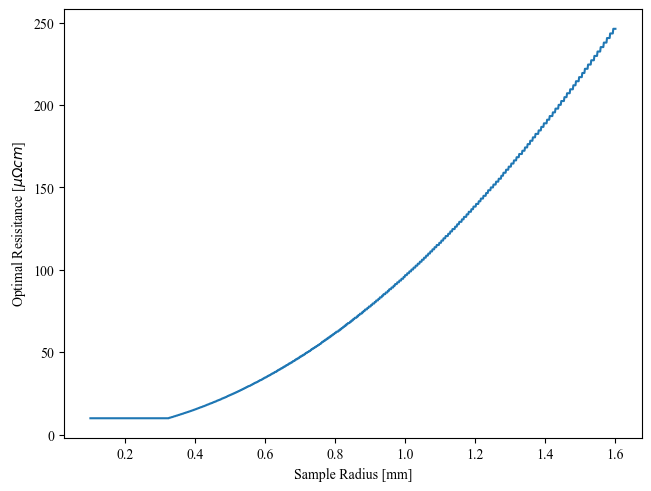

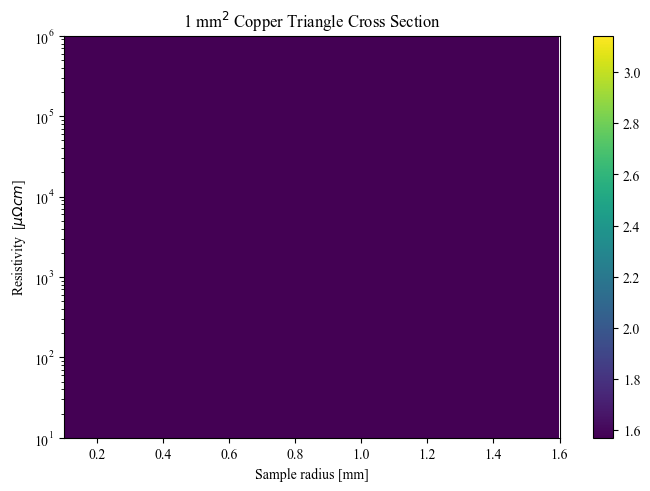

In [89]:
a = np.linspace(1e-4,1.6e-3,1000)#this is the range of radii that the probe can handle
rhos2 = np.logspace(-7,-2,1000)
# rhos = np.linspace(1e-9,1e-3,1000)
best_rhos = np.zeros(len(a),dtype=np.float64)
phases = np.zeros([len(rhos2),len(a)],dtype=np.float64)
for j, r in enumerate(a):
    chis = np.zeros(len(rhos2),dtype=np.complex_)
    for i, rho in enumerate(rhos2):
        rk =(1-1j)*r/get_skin_depth(rho)
        chis[i] = np.angle(2/rk*jv(1,rk)/jv(0,rk)-1)
        phases[i][j] = chis[i].real
    best_rhos[j] = rhos2[np.argmax(abs(np.gradient(chis).real))]

fig = plt.figure(constrained_layout = True)
ax = fig.add_subplot(1, 1, 1)
ax.plot(a*1e3,best_rhos*1e8)
ax.set_xlabel('Sample Radius [mm]')
ax.set_ylabel(r'Optimal Resisitance [$\mu \Omega cm$]')
# ax.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

fig2 = plt.figure(constrained_layout = True)
bx = fig2.add_subplot(1, 1, 1)

p1 = bx.imshow(phases,extent=[a[0]*1e3, a[-1]*1e3, rhos2[0]*1e8, rhos2[-1]*1e8], aspect='auto',vmin=np.pi/2, vmax=np.pi,origin='lower')#,norm=colors.LogNorm(vmin=phases.min(), vmax=phases.max()))
fig.colorbar(p1, ax=bx)
bx.set_ylabel(r'Resistivity  [$\mu \Omega cm$]')
bx.set_xlabel('Sample radius [mm]')
bx.set_yscale('log')
bx.set_title(r'1 mm$^2$ Copper Triangle Cross Section')

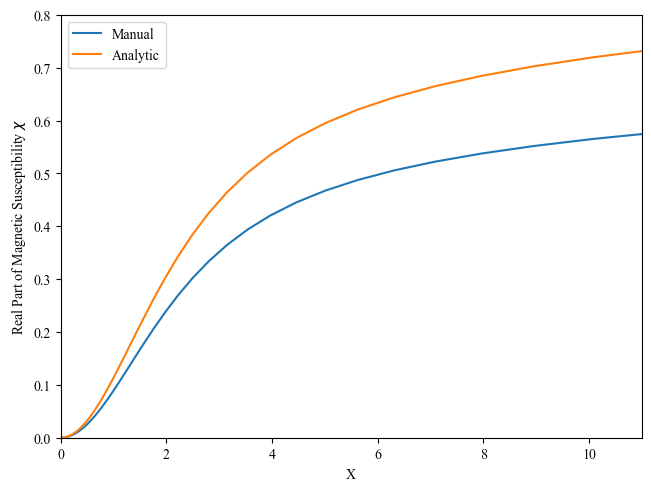

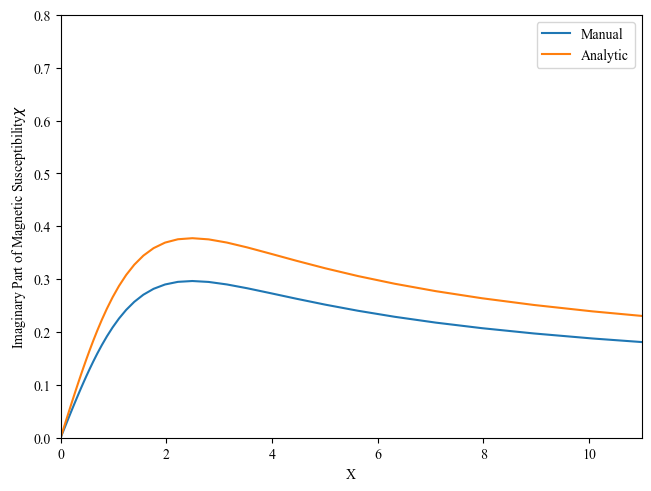

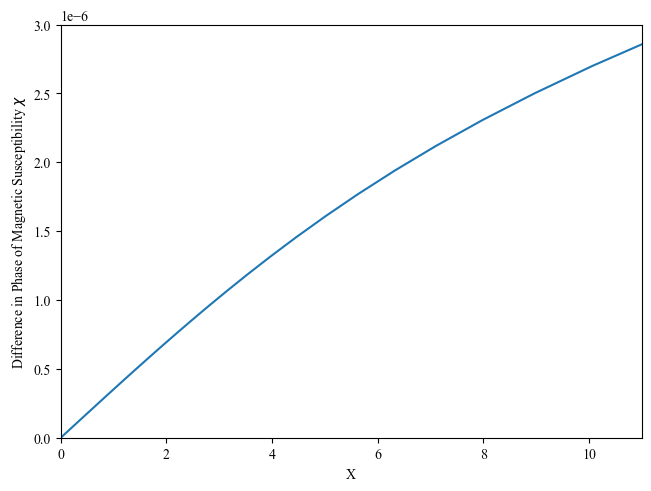

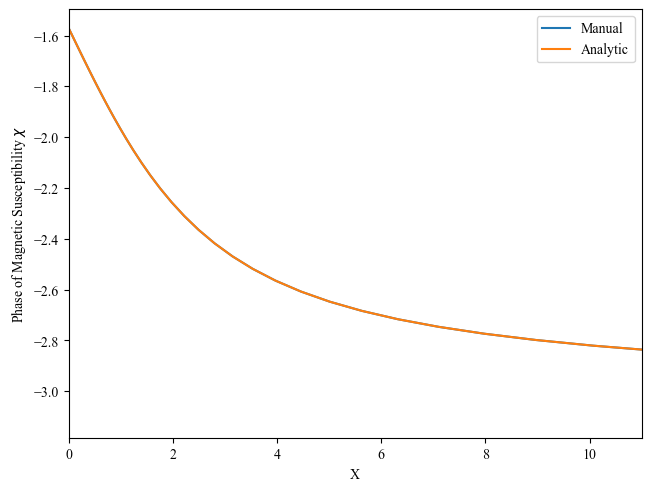

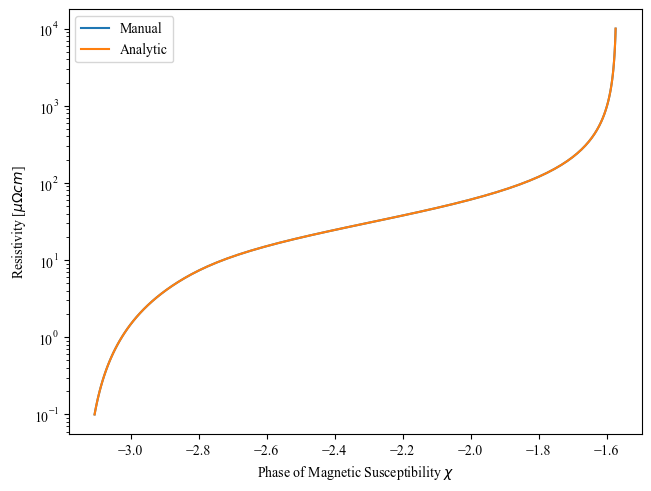

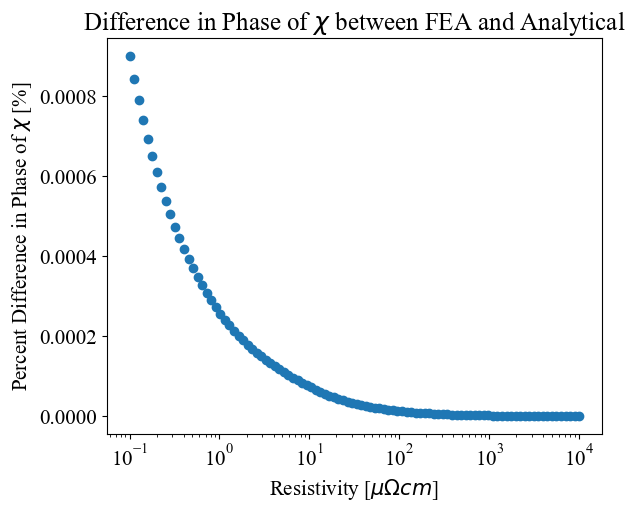

In [5]:
fig1 = plt.figure(constrained_layout = True)
fig2 = plt.figure(constrained_layout = True)
fig3 = plt.figure(constrained_layout = True)
fig4 = plt.figure(constrained_layout = True)
fig5 = plt.figure(constrained_layout = True)
fig6 = plt.figure(constrained_layout = True, figsize= (6,5))
ax = fig1.add_subplot(1, 1, 1)
bx = fig2.add_subplot(1, 1, 1)
cx = fig3.add_subplot(1, 1, 1)
dx = fig4.add_subplot(1, 1, 1)
ex = fig5.add_subplot(1, 1, 1)
fx = fig6.add_subplot(1, 1, 1)
r = .5e-3
X = (r/get_skin_depth(rhos))**2
ax.plot(X,-chis.real)
ax.plot(X,-analchis.real)
ax.set_xlabel(r'X')
ax.set_ylabel(r'Real Part of Magnetic Susceptibility $\chi$')
ax.legend(['Manual','Analytic'])
ax.set_xlim(0,11)
ax.set_ylim(0,.8)

bx.plot(X,-chis.imag)
bx.plot(X,-analchis.imag)
bx.set_xlabel(r'X')
bx.set_ylabel(r'Imaginary Part of Magnetic Susceptibility$\chi$')
bx.legend(['Manual','Analytic'])
bx.set_xlim(0,11)
bx.set_ylim(0,.8)

cx.plot(X,np.angle(analchis)-np.angle(chis))
# cx.plot(X,np.angle(analchis))
cx.set_xlabel(r'X')
cx.set_ylabel(r'Difference in Phase of Magnetic Susceptibility $\chi$')
cx.set_xlim(0,11)
cx.set_ylim(0,3e-6)

dx.plot(X,np.angle(chis))
dx.plot(X,np.angle(analchis))
dx.set_xlabel(r'X')
dx.set_ylabel(r'Phase of Magnetic Susceptibility $\chi$')
dx.legend(['Manual','Analytic'])
dx.set_xlim(0,11)

ex.plot(np.angle(chis),rhos*1e8)
ex.plot(np.angle(analchis),rhos*1e8)
ex.set_yscale('log')
ex.set_ylabel(r'Resistivity [$\mu \Omega cm$]')
ex.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$')
ex.legend(['Manual','Analytic'])

fx.set_title(r'Difference in Phase of $\chi$ between FEA and Analytical',fontsize = 18)
fx.scatter(rhos*1e8,100*(np.angle(chis)-np.angle(analchis))/np.angle(analchis))
fx.set_xlabel(r'Resistivity [$\mu \Omega cm$]',fontsize = 15)
fx.set_ylabel(r'Percent Difference in Phase of $\chi$ [%]',fontsize = 15)
# fx.set_yscale('log')
fx.set_xscale('log')
fx.tick_params(axis='x', labelsize=15)
fx.tick_params(axis='y', labelsize=15)
# fx.legend(['Manual','Analytic'])

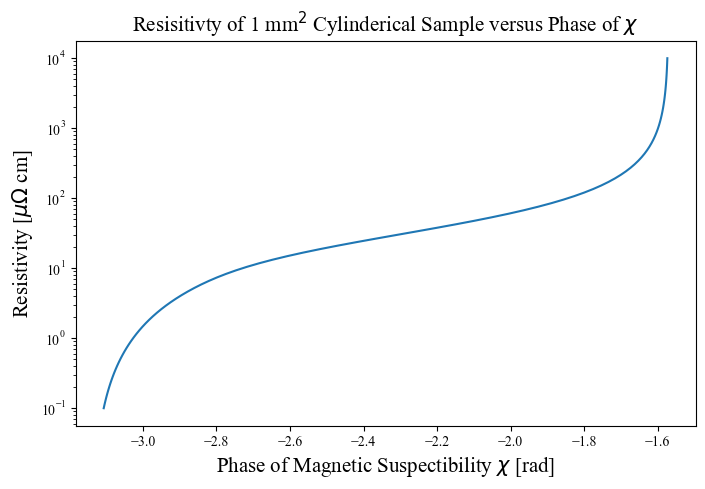

In [24]:

fig,cx = plt.subplots(1,1,figsize = (8,5))
# bx = fig.add_subplot(2, 1, 2)
cx.plot(np.angle(chis),rhos*1e8)
cx.set_ylabel(r"Resistivity [$\mu \Omega$ cm]",fontsize=15)
cx.set_xlabel(r"Phase of Magnetic Suspectibility $\chi$ [rad]",fontsize=15)
cx.set_title(r'Resisitivty of 1 mm$^2$ Cylinderical Sample versus Phase of $\chi$',fontsize=15)
# cx.tick_params(axis='x', labelsize=15)
# cx.tick_params(axis='y', labelsize=15)
# cx.set_xscale('log')
cx.set_yscale('log')
# cx.set_xticks(np.arange(min(abs(np.angle(chis))), max(abs(np.angle(chis))), step=0.2))
# ax.set_xlim([min(rhos),max(rhos)])
# ax.set_ylim([0,max(-chis.real)])
# ax.legend(['Real','Imaginary','Magnitude'])

-2.9532165950281724 -2.9521391566814783 -0.0010774383466940485
2e-08 1.9791145237011963e-08


Text(0.5, 1.0, 'Analytical 1 mm$^2$ Copper Square Cross Section')

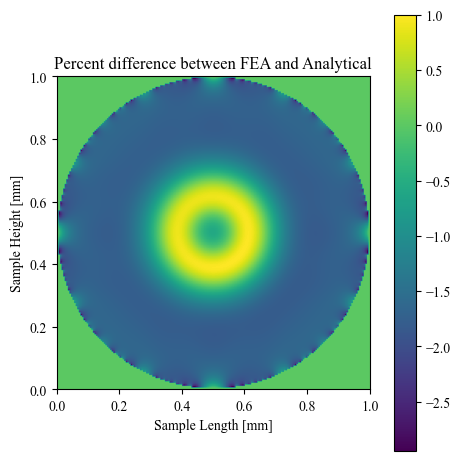

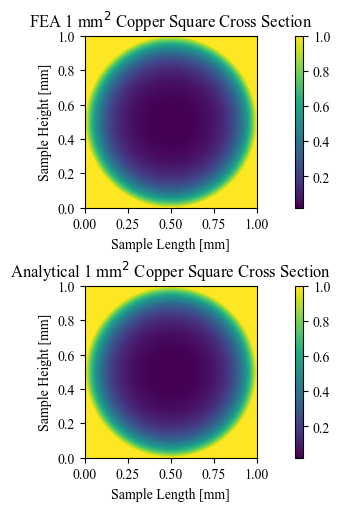

In [143]:
# Analytic Solution Sanity Check
import numpy as np
import matplotlib.pyplot as plt
# import time
# t1 = time.time()
# t2 = time.time()
# duration = t2 - t1

# Define the parameters
rho = 2e-8  # resistivity
spacial_res = 200
iter = 15000

# Define the domain
r = 0.5e-3  # define the radius of the circle
d=2*r
x = np.linspace(0, 2*r, spacial_res)  # x-axis points
y = np.linspace(0, 2*r, spacial_res)  # y-axis points


# get interpolatoion fucniton
rhos3 = np.logspace(-9,-6,1000)
analchis = np.zeros(len(rhos3),dtype=np.complex_)#analytical solution for cylinder
resolution = 200
H0 = 1
for i, rho1 in enumerate(rhos3):
    k =(1-1j)/get_skin_depth(rho1)
    analchis[i] = 2/r/k*jv(1,r*k)/jv(0,r*k)-1
Phase2Resistivty2 = interp1d(np.angle(analchis),rhos3)

# Set the boundary conditions
mask = np.ones((spacial_res, spacial_res))  # initialize the mask to zeros

for i in range(spacial_res):
    for j in range(spacial_res):
        if (x[i] - r)**2 + (y[j] - r)**2 > r**2: #this makes a circle
            mask[i, j] = 0  # outside is zeros


# Define the initial condition
z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
# shape_inds = np.array([])
# for i in range(1, resolution - 1):  # loop over the interior points in x
#     for j in range(1, resolution - 1):  # loop over the interior points in y
#         if mask[i, j] == 1:
#             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
#             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
#             # shape_inds = np.append(shape_inds,(i,j))



z_square = get_square_H(d,get_skin_depth(rho),spacial_res-2)
for i in range(1, resolution - 1):  # loop over the interior points in x
    for j in range(1, resolution - 1):  # loop over the interior points in y
        if mask[i, j] == 1:
            z[i,j] = z_square[i,j]
            # shape_inds = np.append(shape_inds,(i,j))

phases = np.zeros(iter)
skin_depth = get_skin_depth(rho)
k_squared = -2j / (skin_depth)**2 
k = (1 - 1j) / skin_depth
resolution = len(mask)
x = np.linspace(0, s, resolution)  # x-axis points
dx = x[1] - x[0]  # grid spacing in x
# Time to iterate
inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
for n in range(iter):
    for i in range(1, resolution - 1):  # loop over the interior points in x
        for j in range(1, resolution - 1):  # loop over the interior points in y
            if mask[i, j] == 1:  # check if the current point is in the interior
                #update the current point using the finite difference method
                z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    phases[n] = np.angle(double_Integral(z,d)/d**2-1)

# z = get_shape_H(mask,2*r,get_skin_depth(rho),iter)
i1 = np.logical_not(phases<0)
phases[i1]-= 2*np.pi

analytic = get_cylind_H(2*r,get_skin_depth(rho),spacial_res-2)

chi = double_Integral(z,d)/d**2-1
k =(1-1j)/get_skin_depth(rho)
anachi = 2/r/k*jv(1,r*k)/jv(0,r*k)-1
print(np.angle(chi),np.angle(anachi),np.angle(chi)-np.angle(anachi))
try:
    print(rho,Phase2Resistivty2(np.angle(chi)))
except:
    print('error')


fig = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
ax = fig.add_subplot(1, 1, 1)
p = ax.imshow(100*(np.absolute(z)-np.absolute(analytic))/np.absolute(analytic),extent=[0, 1, 0, 1])
fig.colorbar(p, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'Percent difference between FEA and Analytical')

fig2 = plt.figure(constrained_layout = True, figsize=(6, 5))
ax = fig2.add_subplot(2, 1, 1)
bx = fig2.add_subplot(2, 1, 2)
p1 = ax.imshow(np.absolute(z),extent=[0, 1, 0, 1])
p2 = bx.imshow(np.absolute(analytic),extent=[0, 1, 0, 1])
fig.colorbar(p1, ax=ax)
fig.colorbar(p2, ax=bx)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title(r'FEA 1 mm$^2$ Copper Square Cross Section')
bx.set_xlabel('Sample Length [mm]')
bx.set_ylabel('Sample Height [mm]')
bx.set_title(r'Analytical 1 mm$^2$ Copper Square Cross Section')


Text(0, 0.5, 'Difference to Correct result [rad]')

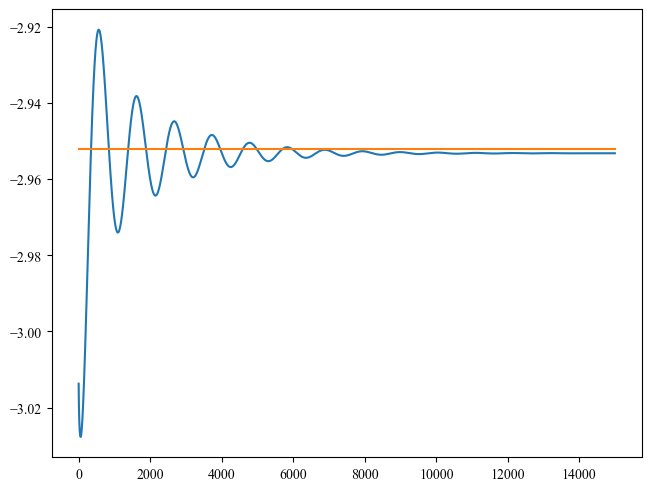

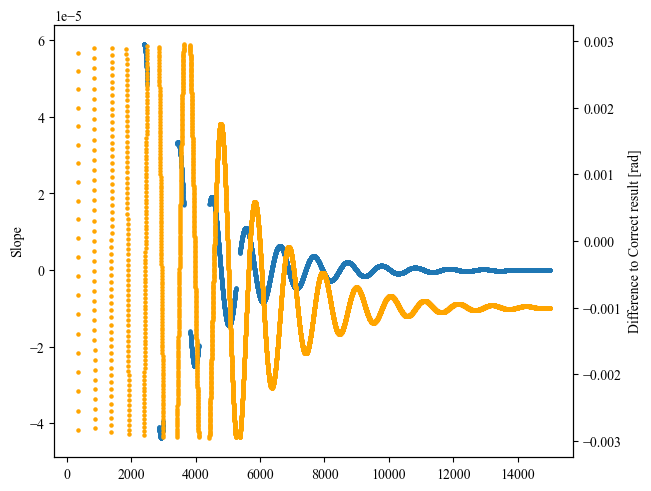

In [141]:
from scipy import optimize
from scipy.signal import find_peaks
# def model1(x, amp, per, phase,offset,decay):
#     return amp *np.exp(-decay*x)*np.cos(2*np.pi*x/per+phase)+offset
# guesses1 = [5,750,2,-3,1e-3]
# parameterlowerbounds1 = np.array([0,0,0,-3.2,0])
# parameterupperbounds1 = np.array([10,3000,2*np.pi,-1.5,1])
# pbounds1 = np.array([parameterlowerbounds1,parameterupperbounds1])
# bestfit = optimize.curve_fit(model1,np.arange(iter),phases, guesses1, bounds=pbounds1)
# bestpars1 = bestfit[0]
# print(bestpars1)

# def model2(x,a,b,c):
#     return a*np.exp(-b*x)+c

# tops = find_peaks(phases)[0]
# bottoms = find_peaks(-phases)[0]
# guesses1 = [5,750,2,-3,1e-3]
# parameterlowerbounds1 = np.array([0,0,0,-3.2,0])
# parameterupperbounds1 = np.array([10,3000,2*np.pi,-1.5,1])
# pbounds1 = np.array([parameterlowerbounds1,parameterupperbounds1])
# bestfit = optimize.curve_fit(model2,np.arange(iter),phases, guesses1, bounds=pbounds1)
# bestpars1 = bestfit[0]
# print(bestpars1)

fig3 = plt.figure(constrained_layout = True)
cx = fig3.add_subplot(1, 1, 1)
cx.plot(np.arange(iter),phases)
# cx.plot(np.arange(iter),bestpars1[0] *np.exp(-bestpars1[4]*np.arange(iter))*np.cos(2*np.pi*np.arange(iter)/bestpars1[1]+bestpars1[2])+bestpars1[3])
cx.plot([0,iter],[np.angle(anachi),np.angle(anachi)])
# cx.plot([0,iter],[-np.pi,-np.pi])

ind50 = np.logical_not(abs((phases-np.angle(anachi))/np.angle(anachi))>0.001)
ind51 = np.logical_and(abs((phases-np.angle(anachi))/np.angle(anachi))<0.001, np.arange(iter)>2000)

fig4 = plt.figure(constrained_layout = True)
dx = fig4.add_subplot(1, 1, 1)
dx.scatter(np.arange(iter)[ind51],np.gradient(phases)[ind51],s=4)
dx.set_ylabel('Slope')
ex = dx.twinx()
ex.scatter(np.arange(iter)[ind50],(phases-np.angle(anachi))[ind50],color = 'orange',s = 5)
ex.set_ylabel('Difference to Correct result [rad]')
